In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [3]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [4]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [5]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("Hour", hour("Datetime")).withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [6]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [8]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain

import fiona

shp = fiona.open('sffind_neighborhoods.shp')

# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

Read SF neighborhood data into Basemap


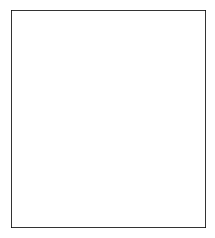

In [9]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'sffind_neighborhoods',
    'SF',
    color='none',
    zorder=2)

print "Read SF neighborhood data into Basemap"

In [10]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 1000000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))
# df_map.count()

In [11]:
def makePoints(dat):
    # Create Point objects in map coordinates from dataframe lon and lat values
    longitude = dat.select('Longitude').rdd.map(lambda x: x[0]).collect()
    latitude = dat.select('Latitude').rdd.map(lambda x: x[0]).collect()
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(longitude,latitude)])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

In [12]:
crime_2017 = crimeDF.where(col('Year').isin(2017))

districts = crimeDF.groupBy('District').agg({'*':'count'}).select('District')\
                  .where(col('District').isNotNull()).rdd.map(lambda x : x[0]).collect()

district_list = [1] * len(districts)
district_pts_list = [1] * len(districts)
for i in range(len(districts)):
    district_list[i] = crime_2017.where(col('District')==districts[i])
    district_pts_list[i] = makePoints(district_list[i])

In [13]:
pts_list = district_pts_list
pts_color = ['red','blue','yellow','magenta','cyan','green','orange','gold','purple','lime','salmon','tomato']
pts_label = districts
pts_lw = [.25] * len(districts)

def bmScatter(pts_index): 
    m.scatter(
    [geom.x for geom in pts_list[pts_index]],
    [geom.y for geom in pts_list[pts_index]],
    10, marker='o', lw=pts_lw[pts_index],
    facecolor=pts_color[pts_index], edgecolor=pts_color[pts_index],
    alpha=0.75, antialiased=True,
    label=pts_label[pts_index], zorder=3)

<Figure size 432x288 with 0 Axes>

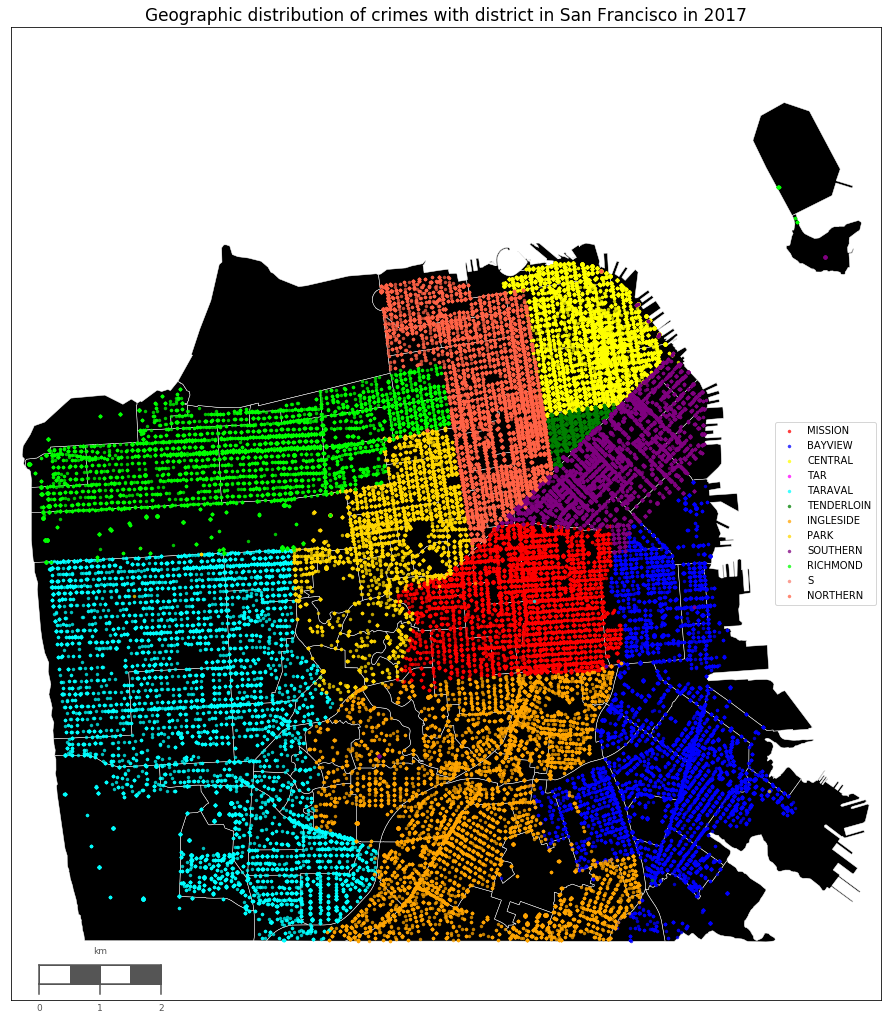

In [15]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

for i in range(len(pts_list)):
    bmScatter(i)
    
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of crimes with district in San Francisco in 2017", size=17)
fig.set_size_inches(15,15)
plt.show()